## **Import Library**

In [ ]:
!pip install emoji
!pip install beautifulsoup4
import os
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 27.8 MB/s eta 0:00:00


## **Persiapan Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

df1 = pd.read_csv('goemotions_1.csv')
df2 = pd.read_csv('goemotions_2.csv')
df3 = pd.read_csv('goemotions_3.csv')
df = pd.concat([df1, df2, df3], ignore_index=True)

df.head()


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### **Filter Data**

In [ ]:
# Memilih kolom yang diinginkan
columns_to_keep = ['text', 'caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']
df = df[columns_to_keep]

# Menghapus baris yang semua nilainya 0 untuk kategori yang diinginkan
df = df[
    (df['caring'] != 0) |
    (df['love'] != 0) |
    (df['gratitude'] != 0) |
    (df['sadness'] != 0) |
    (df['fear'] != 0) |
    (df['anger'] != 0)
]

df.head()

,text,caring,love,gratitude,sadness,fear,anger
0,That game hurt.,0,0,0,1,0,0
3,Man I love reddit.,0,1,0,0,0,0
5,Right? Considering it’s such an important docu...,0,0,1,0,0,0
15,"I appreciate it, that's good to know. I hope I...",0,0,1,0,0,0
23,Now I'm wondering on what I've been missing ou...,0,0,1,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42063 entries, 0 to 211223
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       42063 non-null  object
 1   caring     42063 non-null  int64 
 2   love       42063 non-null  int64 
 3   gratitude  42063 non-null  int64 
 4   sadness    42063 non-null  int64 
 5   fear       42063 non-null  int64 
 6   anger      42063 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 2.6+ MB


### **Hapus Data Duplikat**

In [ ]:
df.duplicated().sum()

16004

In [ ]:
df['text'].duplicated().sum()

19614

In [ ]:
df = df.drop_duplicates(subset ='text')

In [ ]:
df['text'].duplicated().sum()

0

## **Cek Jumlah Data**

In [ ]:
df['sum']= df.iloc[:, 1:].sum(axis=1)
df.head(10)

,text,caring,love,gratitude,sadness,fear,anger,sum
0,That game hurt.,0,0,0,1,0,0,1
3,Man I love reddit.,0,1,0,0,0,0,1
5,Right? Considering it’s such an important docu...,0,0,1,0,0,0,1
15,"I appreciate it, that's good to know. I hope I...",0,0,1,0,0,0,1
23,Now I'm wondering on what I've been missing ou...,0,0,1,0,0,0,1
27,"Yup, not anymore. Keep your blood sugar up! It...",1,0,0,0,0,0,1
29,So happy for [NAME]. So sad he's not here. Ima...,0,0,0,1,0,0,1
34,I’m glad he’s okay but I’m even gladder it’s n...,0,0,1,0,0,0,1
37,"I just came home, what the fuck is this lineup...",0,1,0,0,0,0,1
52,Thanks for the info mate gonna watch out next ...,0,0,1,0,0,0,1


In [ ]:
df['sum'].value_counts()

,count
sum,
1,21627
2,798
3,24


In [ ]:
df = df.drop('sum', axis=1)

In [ ]:
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']
emotion_counts = (df[emotions].sum())
emotion_counts

,0
caring,3601
love,3974
gratitude,4852
sadness,3991
fear,1789
anger,5088


## **Balancing Data**

In [ ]:
from sklearn.utils import resample
def balance_per_category(df, label_columns):
    balanced_data = []
    min_samples = df[label_columns].sum(axis=0).min()  # Ambil jumlah minimum label sebagai target

    for label in label_columns:
        category_data = df[df[label] == 1]  # Ambil data yang sesuai dengan label
        balanced_data.append(resample(category_data, n_samples=min_samples, random_state=42))

    return pd.concat(balanced_data).sample(frac=1, random_state=42)

In [ ]:
df = balance_per_category(df, emotions)
print(df[emotions].sum())

caring       1956
love         1949
gratitude    1946
sadness      1969
fear         1871
anger        1903
dtype: int64


### **Hapus Data Duplikat Setelah di Balancing**

In [ ]:
df['text'].duplicated().sum()

2469

In [ ]:
df = df.drop_duplicates(subset ='text')

In [ ]:
df['text'].duplicated().sum()

0

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = balance_per_category(df, emotions)
print(df[emotions].sum())

caring       1281
love         1304
gratitude    1289
sadness      1292
fear         1227
anger        1231
dtype: int64


In [ ]:
df.iloc[15]

,53371
text,I can’t watch the video the cringe from readin...
caring,0
love,0
gratitude,0
sadness,0
fear,1
anger,0


In [ ]:
df = df.reset_index(drop=True)
df.head(10)

,text,caring,love,gratitude,sadness,fear,anger
0,They 'let themselves go' because they have to ...,1,0,0,0,0,0
1,His definition of a grown man is someone who d...,0,0,0,0,0,1
2,Well he is saying the right sort of things. I'...,1,0,1,0,0,0
3,Someone should make a religion out of this,0,0,0,1,0,0
4,"Well being very close to the border, I know lo...",1,0,0,0,0,0
5,She had it saved on her phone because she was ...,0,0,1,0,0,0
6,The saddest part is that just this morning whe...,0,1,0,1,0,0
7,Wow! Prayers for everyone there.,1,0,0,0,0,0
8,A shitpost crosspost,0,0,0,0,0,1
9,Don't worry about stupid people and you do wha...,0,0,0,0,1,0


## **Split Data**

In [ ]:
from sklearn.model_selection import train_test_split
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']


# Misalkan dataset adalah DataFrame dengan fitur `X` dan label `y`
X = df['text']
y = df[emotions].copy()

# Langkah 1: Pisahkan data training (80%) dan sisanya (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Langkah 2: Pisahkan data testing dan validasi dari sisanya (masing-masing 50% dari 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hasil
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (5414,) (5414, 6)
Validation set: (677,) (677, 6)
Testing set: (677,) (677, 6)


In [ ]:
import os

# Gabungkan data dan simpan ke CSV
datasets = {
    "train_data.csv": pd.concat([X_train, y_train], axis=1),
    "val_data.csv": pd.concat([X_val, y_val], axis=1),
    "test_data.csv": pd.concat([X_test, y_test], axis=1),
}

# Buat folder untuk menyimpan file CSV jika belum ada
output_folder = "/content/drive/MyDrive/sc"

# Simpan dataset ke dalam file CSV
for filename, df in datasets.items():
    df.to_csv(os.path.join(output_folder, filename), index=False)

print("Data berhasil dibagi dan disimpan dalam folder 'output_data'")


Data berhasil dibagi dan disimpan dalam folder 'output_data'


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/sc/train_data.csv')
df_train = df_train.reset_index(drop=True)

In [ ]:
df_train.head()

,text,caring,love,gratitude,sadness,fear,anger
0,Any more comments calling me SWERF for caring ...,0,0,0,0,0,1
1,my heart melted omg [NAME],1,1,0,0,0,0
2,"I got angry briefly, made a post and got over ...",0,0,1,0,0,1
3,"Sorry, I posted this first but then you said s...",1,0,0,0,0,0
4,Well now I have [NAME] in my head for the morn...,0,1,0,0,0,0


In [ ]:
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

In [ ]:
emotion_counts = (df_train[emotions].sum())
emotion_counts

,0
caring,1026
love,1046
gratitude,1045
sadness,1029
fear,983
anger,989


In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/sc/val_data.csv')
df_val = df_val.reset_index(drop=True)

In [ ]:
df_val.head()

,text,caring,love,gratitude,sadness,fear,anger
0,Not even polite if they're driving. The road r...,0,0,0,0,1,0
1,Fierljeppen heck!,0,0,0,0,0,1
2,Vanillas dope tho,0,0,0,0,0,1
3,A lot of injury history for these players. I h...,1,0,0,0,0,0
4,The only advice I'll give is to not come back ...,0,0,0,1,0,0


In [ ]:
emotion_counts = (df_val[emotions].sum())
emotion_counts

,0
caring,121
love,132
gratitude,125
sadness,140
fear,113
anger,118


In [ ]:
print(df_train.shape)
print(df_val.shape)

(5414, 7)
(677, 7)


## **Cleaning Data**

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [ ]:
df_train['text'] = df_train['text'].apply(text_preprocessing_pipeline)
df_val['text'] = df_val['text'].apply(text_preprocessing_pipeline)

In [ ]:
df_train.head()

,text,caring,love,gratitude,sadness,fear,anger
0,any more comments calling me swerf for caring ...,0,0,0,0,0,1
1,my heart melted omg,1,1,0,0,0,0
2,i got angry briefly made a post and got over i...,0,0,1,0,0,1
3,sorry i posted this first but then you said so...,1,0,0,0,0,0
4,well now i have in my head for the morning lov...,0,1,0,0,0,0


## **Train Model**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
target_cols = [col for col in df_train.columns if col not in ['text']]
target_cols

['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(df_val, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,6)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [ ]:
import matplotlib.pyplot as plt

# Menyimpan nilai loss dan metrik
train_losses = []
val_losses = []
accuracies = []
f1_scores_micro = []
f1_scores_macro = []

In [ ]:
def train(epoch):
    model.train()
    total_loss = 0
    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()

        if _ % 500 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

In [ ]:
def validation():
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for data in valid_loader:
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_val_loss = total_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)

    return all_outputs, all_targets


In [ ]:
for epoch in range(EPOCHS):
    train(epoch)
    outputs, targets = validation()

    outputs = np.array(outputs) >= 0.3
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

    accuracies.append(accuracy)
    f1_scores_micro.append(f1_score_micro)
    f1_scores_macro.append(f1_score_macro)



Epoch: 0, Loss: 0.7024175524711609
Epoch: 1, Loss: 0.2916277050971985
Epoch: 2, Loss: 0.19300580024719238
Epoch: 3, Loss: 0.11811570823192596
Epoch: 4, Loss: 0.1571677327156067
Epoch: 5, Loss: 0.0682101771235466
Epoch: 6, Loss: 0.05459292232990265
Epoch: 7, Loss: 0.09321662038564682
Epoch: 8, Loss: 0.03365232050418854
Epoch: 9, Loss: 0.04764130339026451
Epoch: 10, Loss: 0.03355300426483154
Epoch: 11, Loss: 0.039256516844034195
Epoch: 12, Loss: 0.015446275472640991
Epoch: 13, Loss: 0.029193084686994553
Epoch: 14, Loss: 0.00977763906121254
Epoch: 15, Loss: 0.012289784848690033
Epoch: 16, Loss: 0.017932893708348274
Epoch: 17, Loss: 0.014865483157336712
Epoch: 18, Loss: 0.013556011021137238
Epoch: 19, Loss: 0.009379465132951736


In [ ]:
# Setelah semua epoch selesai, cetak hasil
print("\nTraining complete. Final results:")
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}, Train Loss: {train_losses[epoch]}, Validation Loss: {val_losses[epoch]}, "
          f"Accuracy Score = {accuracies[epoch]}, F1 Score (Micro) = {f1_scores_micro[epoch]}, "
          f"F1 Score (Macro) = {f1_scores_macro[epoch]}")


Training complete. Final results:
Epoch: 0, Train Loss: 0.43682065220440136, Validation Loss: 0.289893315597014, Accuracy Score = 0.48005908419497784, F1 Score (Micro) = 0.6295358649789029, F1 Score (Macro) = 0.6046586057354361
Epoch: 1, Train Loss: 0.2580887501730638, Validation Loss: 0.23183755983005871, Accuracy Score = 0.638109305760709, F1 Score (Micro) = 0.7406296851574213, F1 Score (Macro) = 0.7375636033774952
Epoch: 2, Train Loss: 0.19737557575983158, Validation Loss: 0.21803902089595795, Accuracy Score = 0.6971935007385525, F1 Score (Micro) = 0.7741477272727273, F1 Score (Macro) = 0.7722624944033666
Epoch: 3, Train Loss: 0.15798115370904697, Validation Loss: 0.21025656976483084, Accuracy Score = 0.7355982274741507, F1 Score (Micro) = 0.8033240997229917, F1 Score (Macro) = 0.8007490289876115
Epoch: 4, Train Loss: 0.12158271661576103, Validation Loss: 0.20083970915187488, Accuracy Score = 0.7488921713441654, F1 Score (Micro) = 0.8136518771331058, F1 Score (Macro) = 0.8128843132

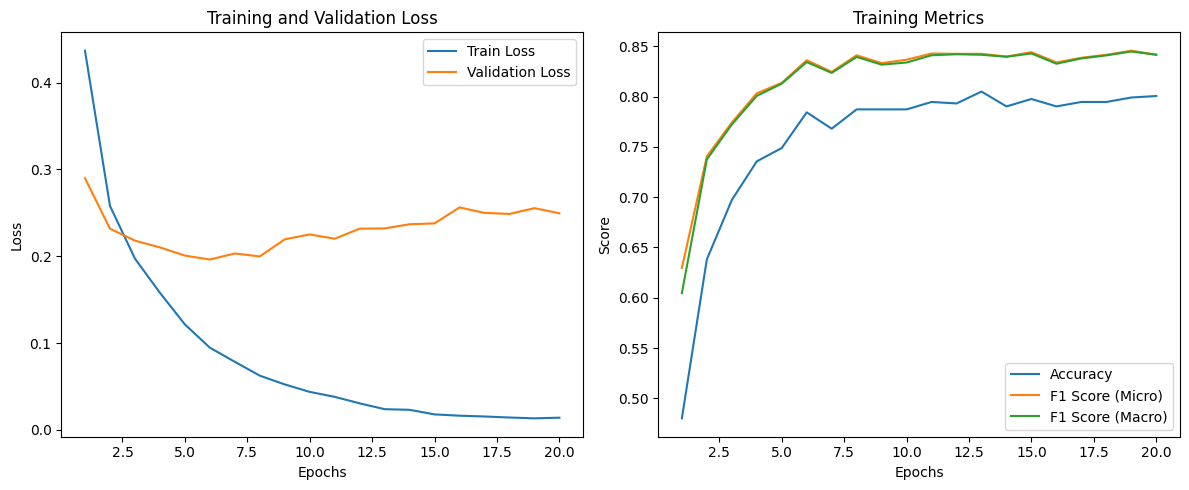

In [ ]:
# Menggambar kurva
def plot_metrics():
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy and F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.plot(epochs, f1_scores_micro, label='F1 Score (Micro)')
    plt.plot(epochs, f1_scores_macro, label='F1 Score (Macro)')
    plt.title('Training Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menggambar kurva setelah pelatihan
plot_metrics()

In [ ]:
## Save only the model's state_dict
torch.save(model.state_dict(), '/content/drive/MyDrive/sc/modelroberta_2.pth')
print("Model's state_dict saved successfully!")


Model's state_dict saved successfully!


In [ ]:
import pickle

# Save the model
with open('/content/drive/MyDrive/sc/modelroberta_2.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as 'modelroberta_2.pkl'")


Model saved as 'modelroberta_2.pkl'


In [ ]:
from sklearn.metrics import classification_report
# Print Classification Report
print("\nClassification Report:")
print(classification_report(targets, outputs, target_names=target_cols))



Classification Report:
              precision    recall  f1-score   support

      caring       0.79      0.79      0.79       121
        love       0.93      0.88      0.90       132
   gratitude       0.92      0.90      0.91       125
     sadness       0.85      0.79      0.81       140
        fear       0.83      0.88      0.86       113
       anger       0.74      0.81      0.78       118

   micro avg       0.84      0.84      0.84       749
   macro avg       0.84      0.84      0.84       749
weighted avg       0.84      0.84      0.84       749
 samples avg       0.83      0.84      0.83       749



In [ ]:
def predict(text):
    # Preprocess input text
    text = text_preprocessing_pipeline(text)
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True
    )

    ids = torch.tensor(inputs['input_ids']).unsqueeze(0).to(device)
    mask = torch.tensor(inputs['attention_mask']).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(inputs["token_type_ids"]).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(ids, mask, token_type_ids)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs = outputs >= 0.3  # Binarize the predictions

    # List of emotion categories (adjust based on your dataset)
    emotion_labels = ['joy', 'love', 'gratitude', 'sadness', 'fear', 'anger']

    # Get the names of emotions that have a True prediction
    detected_emotions = [emotion_labels[i] for i in range(len(emotion_labels)) if outputs[0][i]]

    # Return the detected emotions as a string or list
    return detected_emotions if detected_emotions else "No emotion detected"



In [ ]:
# Example prediction
sample_text = "It really is! I loved everything about it. I'm so happy my friend told me about the franchise :)"
predictions = predict(sample_text)
print(predictions)

['love']


In [ ]:

# Example prediction
sample_text = "I’m very sorry for the loss of your friend."
predictions = predict(sample_text)
print(predictions)

['joy', 'sadness']
